# Data Wrangling

## Content
- [Import Necessary Modules and Datasets](#import)
- [Test Data by Linear Regression](#test_data)
- [Record Linkage](#linking)
- [Convert Dtypes](#etl)
- [Data Quality Analysis](#dqa)
- [Measure Quality](#measurequality)
- [States and Cities](#states)
- [Four Quarter Scores](#scores)
- [Used in Quality Measure Five Star Rating](#fivestar)

### Import Necessary Packages<a id = 'import'></a>

In [1]:
## Necessary packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pandas_profiling

from io import BytesIO
from zipfile import ZipFile
import urllib
import recordlinkage

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import sklearn.model_selection as m_sel

In [2]:
## Unzip and read file of Penality dataset
url = urllib.request.urlopen('https://github.com/jonahwinninghoff/Springboard_Capstone_Project/blob/main/Assets/NH_Penalties_Jun2021.csv.zip?raw=true')
file = ZipFile(BytesIO(url.read()))
csv= file.open('NH_Penalties_Jun2021.csv')
penalty = pd.read_csv(csv, encoding='cp1252')
file.close()

In [3]:
## Unzip and read file of MDS Measure Quality dataset
url = urllib.request.urlopen('https://github.com/jonahwinninghoff/Springboard_Capstone_Project/raw/main/Assets/NH_QualityMsr_MDS_Jun2021.csv.zip')
file = ZipFile(BytesIO(url.read()))
csv = file.open("NH_QualityMsr_MDS_Jun2021.csv")
quality = pd.read_csv(csv, encoding='cp1252')
file.close()

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Test Data by Linear Regression <a id = 'test_data'></a>

In [4]:
## Split data by 70 and 30
df = quality[['Provider Zip Code','Measure Code',
              'Four Quarter Average Score']].dropna(how = 'any', axis = 0)
dataset_X, dataset_y = df[['Provider Zip Code','Measure Code']], df['Four Quarter Average Score']
X_train, X_test, y_train, y_test = m_sel.train_test_split(dataset_X, dataset_y, 
                                                    test_size=0.20, 
                                                    random_state=666)

In [5]:
# Create 10 folds of cross validation and use linear regression
model = LinearRegression()
cv = m_sel.KFold(n_splits=10, random_state=444, shuffle=True)
print(model.fit(X_train, y_train))

LinearRegression()


In [6]:
# Create the 10 fold average metrics
thenames = ['Accuracy','Mean Absolute Error','Brier Score']
scorings = ['r2','neg_mean_absolute_error','neg_mean_squared_error']
scores = {}

for i in enumerate(thenames):
    scores[thenames[i[0]]] = m_sel.cross_val_score(model, 
                                                   X_train, y_train,
                                                   cv=cv, scoring=scorings[i[0]])
    scores[thenames[i[0]]] = np.absolute(round(np.mean(scores[thenames[i[0]]]),3))

In [7]:
print('The data problem that seems solvable is because the result is: '+str(scores)+
      ', even though both average MSE and average MAE is extremely high.')

The data problem that seems solvable is because the result is: {'Accuracy': 0.209, 'Mean Absolute Error': 26.53, 'Brier Score': 1053.954}, even though both average MSE and average MAE is extremely high.


### Record Linkage <a id = 'linking'></a>

In [8]:
# Check if both have some same names of columns
compare = {}
for i in penalty.columns:
    if i in quality.columns:
        compare[i] = ['V']
    else:
        compare[i] = ['X']

display(pd.DataFrame(compare).T.reset_index().rename(columns={
    'index':'Both datasets',0:'do have'}))

Both datasets do have
0         Federal Provider Number       V
1                   Provider Name       V
2                Provider Address       V
3                   Provider City       V
4                  Provider State       V
5               Provider Zip Code       V
6                    Penalty Date       X
7                    Penalty Type       X
8                     Fine Amount       X
9       Payment Denial Start Date       X
10  Payment Denial Length in Days       X
11                       Location       V
12                Processing Date       V

In [9]:
# Instaniate the record linkage
indexer = recordlinkage.Index()
indexer.block('Federal Provider Number')
potential_links = indexer.index(quality, penalty)

In [10]:
# Create the criteria for record linkage
compare = recordlinkage.Compare()

compare.string('Provider Name', 'Provider Name', threshold = 0.95)
compare.string('Provider Address', 'Provider Address', threshold = 0.95)
compare.exact('Provider State', 'Provider State')
compare.exact('Provider Zip Code', 'Provider Zip Code')
compare.string('Location', 'Location', threshold = 0.7)
compare.exact('Processing Date', 'Processing Date')

# The comparison vectors
compare_vectors = compare.compute(potential_links, quality, penalty)

In [11]:
# Describe the comparing vectors
display(compare_vectors.describe())

0        1        2        3        4        5
count  11348.0  11348.0  11348.0  11348.0  11348.0  11348.0
mean       1.0      1.0      1.0      1.0      1.0      1.0
std        0.0      0.0      0.0      0.0      0.0      0.0
min        1.0      1.0      1.0      1.0      1.0      1.0
25%        1.0      1.0      1.0      1.0      1.0      1.0
50%        1.0      1.0      1.0      1.0      1.0      1.0
75%        1.0      1.0      1.0      1.0      1.0      1.0
max        1.0      1.0      1.0      1.0      1.0      1.0

In [12]:
# Check if all are matched
print(compare_vectors.sum(axis=1).value_counts().sort_index(ascending=False))

6.0    11348
dtype: int64


In [13]:
df = penalty.merge(quality, how = 'right', on = 'Federal Provider Number', suffixes = ('_merged',''), copy = True)

In [14]:
# Remove redundancies in column names and use for check duplicaties
nomerged = []
for i in range(len(df.columns)):
    if df.columns.str.endswith('merged', na=False)[i]:
        None
    else:
        nomerged.append(df.columns[i])

In [15]:
result = any(df[nomerged].duplicated())

if result == False:
    print('There is none of duplications existed in data')
else:
    cleaned_df[cleaned_df.duplicated()]

There is none of duplications existed in data


In [16]:
# Complete dataset
dataset = df[nomerged].copy()

### Convert Dtypes <a id = 'etl'></a>

In [17]:
## Create easy and fast way to convert data types
def multi_astypes(data,string):
    diction = {}                              # Create empty dict
    thedict = {'o':'object', 'i':'int64', 'f':'float64', 
               'b':'bool', 'd':'datetime64', 't':'timedelta', 
               'c':'category'}
    thelist = list(string.lower())         # EX: obc -> [o,b,c]
    Error = 'Please use any letters of o, i, f, b, d, t, and c. Each letter represents the first letters of '+str(thedict)
    
    for i in range(0,len(thelist)):
        if thelist[i] in thedict:
            thetype = thedict[thelist[i]]# EX: thedict[o] -> object
            diction[data.columns[i]] = thetype
        else:
            raise ValueError(Error)
            break
        
    return data.astype(diction)            # Convert all columns

In [18]:
# Convert all data types at once
clean_dataset = multi_astypes(dataset,'odcfdfooooiiocffffffffffcood')

#### See what changes in data types

In [19]:
dataset_dtypes = pd.DataFrame(dataset.dtypes).reset_index()
clean_dataset_dtypes = pd.DataFrame(clean_dataset.dtypes).reset_index()

dataset_dtypes.columns = ['variable', 'dtype']
clean_dataset_dtypes.columns = ['variable', 'cleaned dtype']
comp = dataset_dtypes.merge(clean_dataset_dtypes, how = 'inner', 
                     on = 'variable')

comp['dtype'] = comp['dtype'].astype('str')
comp['cleaned dtype'] = comp['cleaned dtype'].astype('str')

display(comp[comp['dtype'] != comp['cleaned dtype']])

variable   dtype   cleaned dtype
1                               Penalty Date  object  datetime64[ns]
2                               Penalty Type  object        category
4                  Payment Denial Start Date  object  datetime64[ns]
13                             Resident type  object        category
24  Used in Quality Measure Five Star Rating  object        category
27                           Processing Date  object  datetime64[ns]

### Data Quality Analysis <a id='dqa'></a>

In [20]:
profile = pandas_profiling.ProfileReport(
    clean_dataset, title="Data Quality Analysis")

In [21]:
display(profile)

Summarize dataset:   0%|          | 0/41 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [22]:
profile.to_file("your_report.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

#### Data Quality Analysis - Key Points:
- `Federal Provider`, `Measure Period`, and `Processing Date` are useless.
- `Footnote` in each variable is useless.
- `Measure Score` in each variable is bimodally distributed.
- `Penalty` Date become too often after 01-25-2020
- `Penalty Type` has most number of fines than that of payment denial fine.
- `Fine Amount` is negatively exponentially distributed.
- `Payment Denial Start Date` seems to have seasonal behavior.
- `Provider Name` < `Provider Address`
- `Provider State` variable contains 53 different states, not 50.
- `Provider Zip Code` is unique 9181 values in total and nonparametrically distributed.
- `Measure Code` = `Measure Description` in total 18 unique values.
- `Resident Type` has most number of long stay than that of short stay.
- `Used in Quality Measure Five Star Rating` has number of `No` equal to that of `Yes`.

In [23]:
cleaned_dataset = clean_dataset.drop(columns=['Federal Provider Number','Footnote for Q1 Measure Score',
                            'Footnote for Q2 Measure Score','Footnote for Q3 Measure Score',
                            'Footnote for Q4 Measure Score','Footnote for Four Quarter Average Score',
                            'Measure Period','Processing Date'])

### Measure Quality <a id='measurequality'></a>

#### Check duplications

In [24]:
result = any(cleaned_dataset.duplicated())

if result == False:
    print('There is none of duplications existed in data')
else:
    cleaned_df[cleaned_df.duplicated()]

There is none of duplications existed in data


#### What if measure scores remove all missing values and zeros?

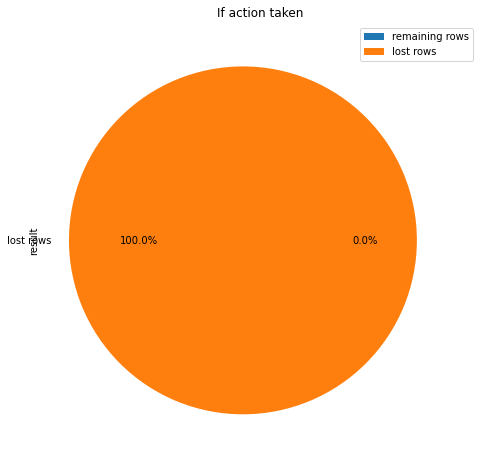

In [25]:
## Copy the data for experiment
guinea_pig = cleaned_dataset.copy()

guinea_pig = guinea_pig.dropna(how = 'any', axis = 0)    # Drop all NaN in every row
guinea_pig = guinea_pig[~(guinea_pig==0.0).any(          # Drop all zeros in every row
    axis = 1)]

# The result is:
pie_chart = pd.DataFrame({"result":[len(guinea_pig),len(cleaned_dataset)-len(guinea_pig)]},
                        index = ['remaining rows', 'lost rows'])

pie_chart.plot.pie(y='result', figsize=(8, 8), autopct='%1.1f%%', explode=(0, 0.1), title = 'If action taken')
plt.show()

#### What if average measure score alone remove all missing values and zeros?

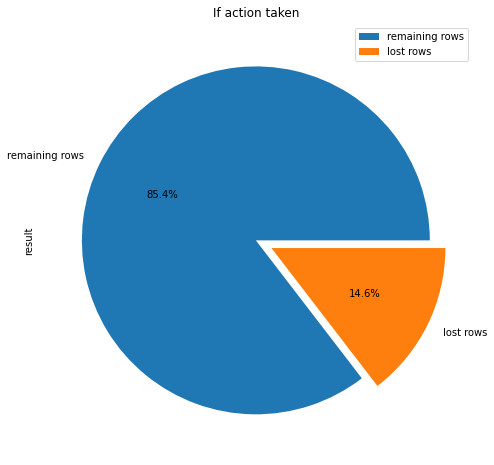

In [26]:
## Copy the dataframe for second experiment
guinea_pig = cleaned_dataset.copy()

guinea_pig = guinea_pig[guinea_pig['Four Quarter Average Score'].notnull()]  # Remove NaN only in one column
guinea_pig = guinea_pig[guinea_pig['Four Quarter Average Score'] != 0]       # Remove zeros only in one column


# The result is:
pie_chart = pd.DataFrame({"result":[len(guinea_pig),len(cleaned_dataset)-len(guinea_pig)]},
                        index = ['remaining rows', 'lost rows'])

pie_chart.plot.pie(y='result', figsize=(8, 8), autopct='%1.1f%%', explode=(0, 0.1), title = 'If action taken')
plt.show()

#### The latter course of action is chosen

In [27]:
cleaned_dataset = cleaned_dataset[cleaned_dataset['Four Quarter Average Score'].notnull()]
cleaned_dataset = cleaned_dataset[cleaned_dataset['Four Quarter Average Score'] != 0]

### States and Cities <a id='states'></a>

In [28]:
# Copy and paste from https://gist.github.com/JeffPaine/3083347
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

In [29]:
# PR and GU are US territories, so remove them
print(cleaned_dataset[~cleaned_dataset['Provider State'].isin(states)]['Provider State'].unique())
cleaned_dataset = cleaned_dataset[cleaned_dataset['Provider State'].isin(states)]

['PR' 'GU']


In [30]:
melted_df = cleaned_dataset.melt(id_vars = ['Provider Name', 'Provider Address', 'Provider City', 'Provider State',
                           'Provider Zip Code', 'Measure Code', 'Measure Description',
                           'Resident type','Used in Quality Measure Five Star Rating', 
                           'Location'],
                value_vars =['Q1 Measure Score', 'Q2 Measure Score','Q3 Measure Score', 
                             'Q4 Measure Score','Four Quarter Average Score'],
                var_name ='Type of MS', value_name ='MS')

threshold = melted_df['MS'].agg('median')

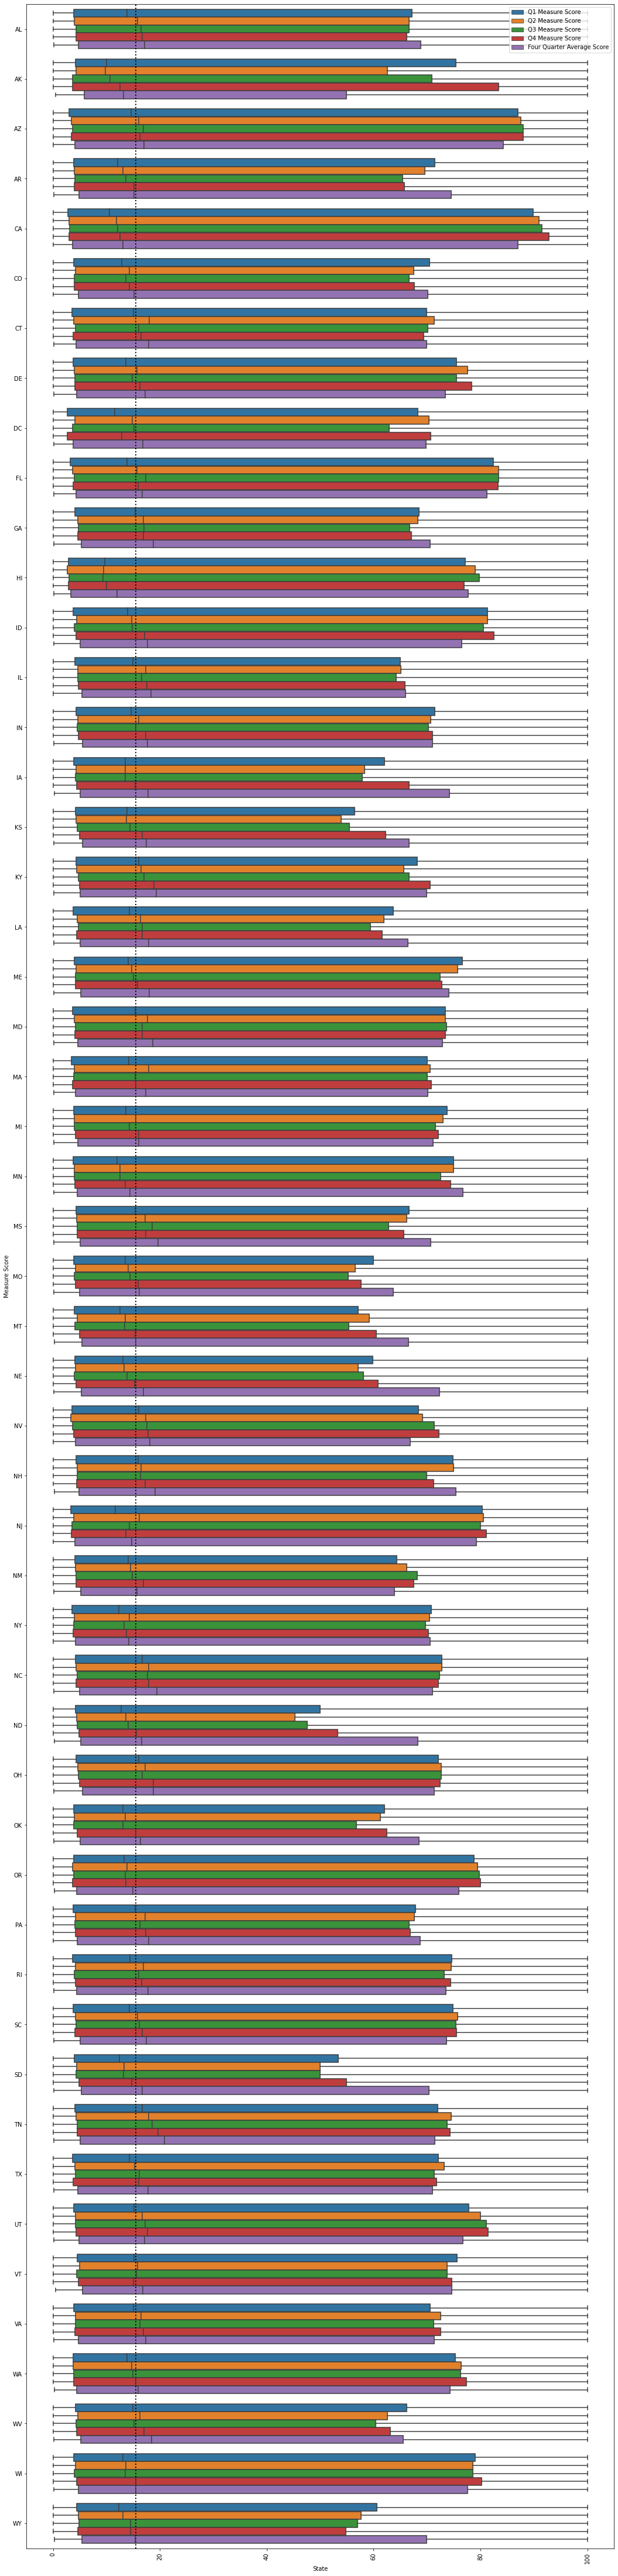

In [31]:
plt.subplots(figsize=(18, 80))
sns.boxplot(y='Provider State', x='MS', hue='Type of MS', data=melted_df,orient="h")
plt.xticks(rotation='vertical')
plt.axvline(x=threshold,linewidth=2, color='black',linestyle=':')
plt.legend( loc = 'upper right')
plt.ylabel('Measure Score')
plt.xlabel('State')
plt.show()

### Four Quarter Scores <a id = 'scores'></a>

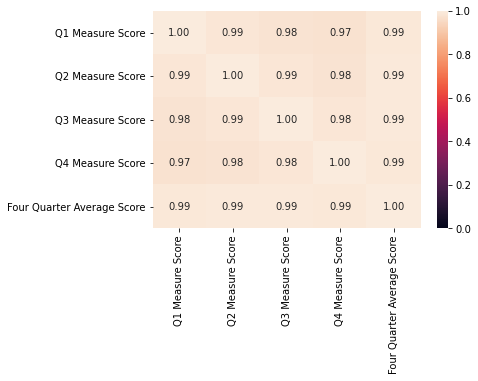

In [32]:
sns.heatmap(cleaned_dataset[['Q1 Measure Score', 'Q2 Measure Score',
                             'Q3 Measure Score', 'Q4 Measure Score', 
                             'Four Quarter Average Score']].corr(),
           vmin=0, vmax=1, annot=True,  fmt='.2f')
plt.show()

In [33]:
## As indicated by above, Quarter 1-4 scores are highly correlated to Average score, so remove them
cleaned_dataset = cleaned_dataset.drop(['Q1 Measure Score', 'Q2 Measure Score',
                                        'Q3 Measure Score', 'Q4 Measure Score'],axis=1)

In [34]:
cleaned_dataset.columns

Index(['Penalty Date', 'Penalty Type', 'Fine Amount',
       'Payment Denial Start Date', 'Payment Denial Length in Days',
       'Provider Name', 'Provider Address', 'Provider City', 'Provider State',
       'Provider Zip Code', 'Measure Code', 'Measure Description',
       'Resident type', 'Four Quarter Average Score',
       'Used in Quality Measure Five Star Rating', 'Location'],
      dtype='object')

### `Used in Quality Measure Five Star Rating` <a id = 'fivestar'></a>

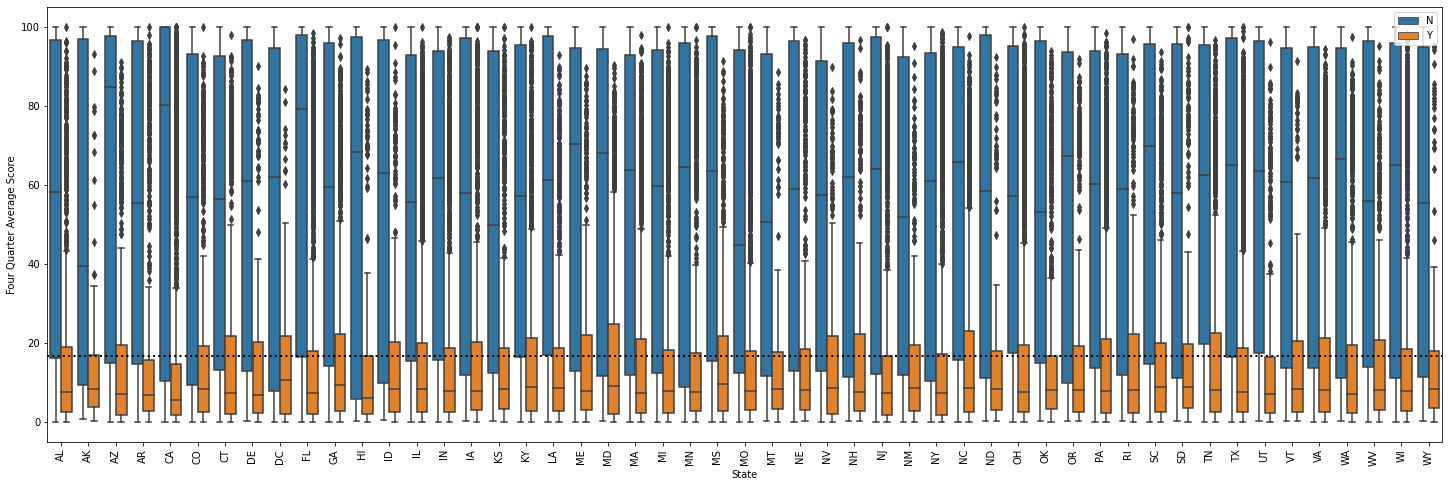

In [35]:
plt.subplots(figsize=(25, 8))
sns.boxplot(x='Provider State', y='Four Quarter Average Score', hue='Used in Quality Measure Five Star Rating', data=cleaned_dataset,orient="v")
plt.xticks(rotation='vertical')
plt.axhline(y=cleaned_dataset['Four Quarter Average Score'].agg('median'),linewidth=2, color='black',linestyle=':')
plt.legend( loc = 'upper right')
plt.ylabel('Four Quarter Average Score')
plt.xlabel('State')
plt.show()

In [36]:
missing_checks = ['Provider Name', 'Provider State', 'Provider Address',
                  'Provider Zip Code', 'Provider City','Location', 
                  'Resident type', 'Used in Quality Measure Five Star Rating',
                 'Measure Description', 'Measure Code']
for i in missing_checks:
    print('Missing '+i+'?: '+str(cleaned_dataset[i].isna().any()))

Missing Provider Name?: False
Missing Provider State?: False
Missing Provider Address?: False
Missing Provider Zip Code?: False
Missing Provider City?: False
Missing Location?: False
Missing Resident type?: False
Missing Used in Quality Measure Five Star Rating?: False
Missing Measure Description?: False
Missing Measure Code?: False


In [37]:
cleaned_dataset.to_json("cleaned_data", 
                   compression="zip")